# Are more famous people dying in 2016 than in typical years? 

Is 2016 really worse than other years? 

More objectively - is there a reason why it seems like more famous people have.... *oh, literally as I was writing this, the news announced Carrie Fisher has gone...*

**Idea 1:** The number of famous people is generally increasing and this has been happening for while now. That ever increasing number of celebrities is now feeding through into an increased number of older celebrities, whose deaths now **seem** to be over-represented but in fact is due to having an increased number of older celebrities who are disappearing at a normal rate

# Let's Get Data
Let's use beautiful soup to scrape some data from wikipedia and play with it.

In [5]:
# Import the libraries we need
import string
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import urllib
import re
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime

%matplotlib inline

Let's see how bad it's been by scraping wikipedia's <a href='https://en.wikipedia.org/wiki/Deaths_in_2016'>2016 Death List</a>

In [24]:
# A function to get a list of death dates from wikipedia's 'Death in 2016 Page'
def get_2016_deaths():
    ages_2016=[]
    expr = re.compile('\d+')
    # Get the ages of 100 random people
    with urllib.request.urlopen('https://en.wikipedia.org/wiki/Deaths_in_2016') as response:
        soup = BeautifulSoup(response,'html5lib')
        search = soup.findAll('li')
        #search = soup.findAll('li', {'class' : 'new'})
        for s in search:
            if re.match("^[a-zA-Z]+.*", s.text):
                if(s.text[0].isalpha()):
                    if(len(re.findall('\d+', s.text))>0):
                        if(int(re.findall('\d+', s.text)[0])<120):
                            ages_2016.append(int(re.findall('\d+', s.text)[0]))
    return ages_2016

deaths_2016=get_2016_deaths()

How are these distributed?

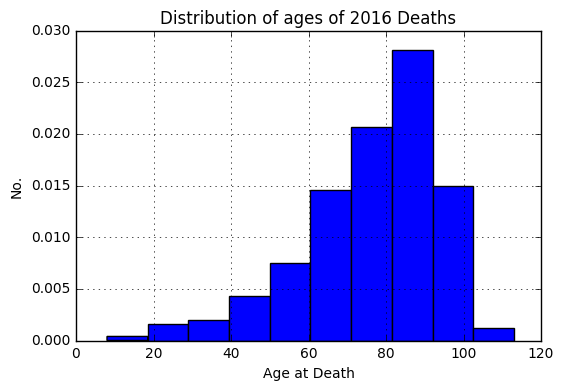

In [25]:
s_2016 = pd.Series(deaths_2016)
az=s_2016.hist(normed=True)
az.set_xlabel('Age at Death')
az.set_ylabel('No.')
az.set_title('Distribution of ages of 2016 Deaths')

What year were these people born? We can find this very easily:

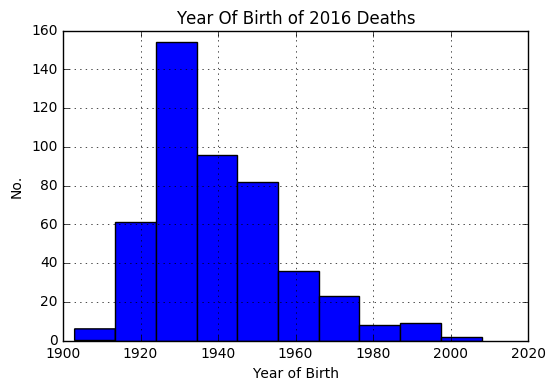

In [384]:
df_2016=pd.DataFrame(s_2016)
df_2016['YoB']=2016-df_2016
av=df_2016['YoB'].hist()
av.set_xlabel('Year of Birth')
av.set_ylabel('No.')
av.set_title('Year Of Birth of 2016 Deaths')

Offhand, the distribution doesn't look too surprising - maybe it's more an issue of quantity, as initially suspected

# What is normal?

Wikipedia also has pages for 'notable' people. As a first approximation, let's say that 'notable' ~ 'famous'. Even if this isn't true, a large enough random sample of notables should yield a random enough sample of celebrities within the notables. Surely!

The function below will fetch n random 'notable' ages from wiki, but takes a while to run, I'd recommend using the CSV in the repo

In [385]:
# Wikipedia lists 807,288 'Living Notable People'
# MAY TAKE A WHILE TO RUN! YOU'LL BE FASTER LOADING A CSV IN 
# THE CELL BELOW!
#
def get_notables_from_wiki(n):
    ages=[]
    expr = re.compile('\d+')
    while (len(ages)<1000):
    # Get the ages of 100 random people
        with urllib.request.urlopen('https://en.wikipedia.org/wiki/Special:RandomInCategory/Living_people') as response:
            soup = BeautifulSoup(response,'html5lib')
            # Use BF to find the span with the age value
            spans = soup.find_all('span', {'class' : 'noprint ForceAgeToShow'})
            if(spans):
                # Find the age - the number - '\d+' in regex, and store)
                ages.append(int(re.findall('\d+', spans[0].text)[0]))
    print('Complete: fetched 1000 ages')
    # Create a pandas series to store the ages
    s = pd.Series(ages)
    # Write out the ages to a csv to avoid loading up wikipedia in future
    s.to_csv('random_wiki_ages.csv', sep=',')
    return ages

Load the randomly selected ages of notables and put them into a pandas data frame and have a look at the distribution of the ages:

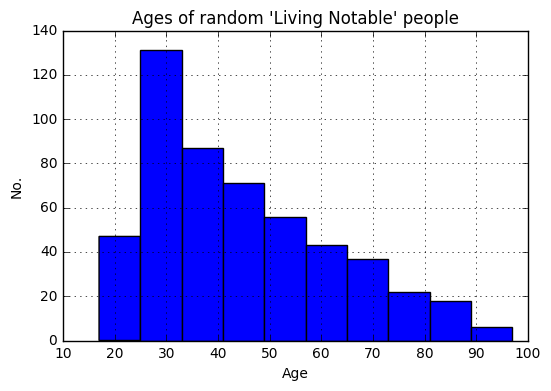

In [386]:
df_wiki = pd.read_csv('random_wiki_ages_1.csv',names=['index', 'Age'])
ax = df_wiki['Age'].hist()
ax.set_xlabel("Age")
ax.set_ylabel("No.")
ax.set_title("Ages of random 'Living Notable' people")

As guessed - there are a lot more 'young' notables, though it's worth noting(!) that while this could be as a result of an ever increasing number of famous people, the following effects will also be in play:

**a)** few famous children (fame typically comes when you do something I suppose)

**b)** inevitably, older people are more likely to die, so there will be a 'natural' drop off in 'Living' notables

Let's look at when they were born:

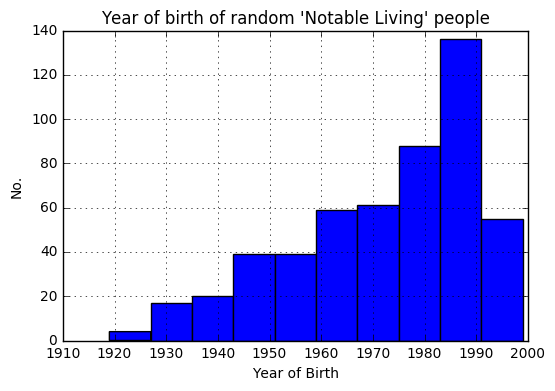

In [387]:
df_wiki['YoB']=2016-df_wiki['Age']
ay=df_wiki['YoB'].hist()
ay.set_xlabel('Year of Birth')
ay.set_ylabel('No.')
ay.set_title("Year of birth of random 'Notable Living' people")

Since we've got a list of **living** notables, we probably need to know how likely it is that a notable born in X year is alive today.

Let's get some life expectancy data. I've used <a href='http://visual.ons.gov.uk/how-has-life-expectancy-changed-over-time/'>UK life expectancy from the ONS</a> as an approximation for the notables from wiki. Possibly a poor approximation, but we'll see

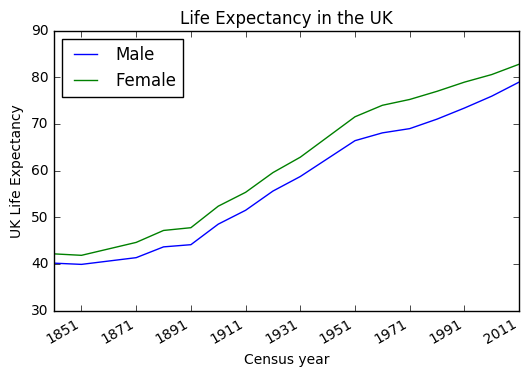

In [388]:
from datetime import datetime
df_life_ex = pd.read_csv('life_expectancy_1841-20111.csv')
df_life_ex.dropna(inplace=True)
df_life_ex['Census year'] = df_life_ex['Census year'].apply(lambda d: datetime.strptime(d, "%Y"))
df_life_ex.index = df_life_ex['Census year']
ay = df_life_ex['Male'].plot()
ay.plot(df_life_ex['Female'])
ay.set_ylabel('UK Life Expectancy')
ay.legend(loc='upper left')
ay.set_title('Life Expectancy in the UK')

Life expectancy looks like you'd expect - a signficant increase starting around 1900, with the advent of modern medicine, antibiotics etc and a more gradual increase since the 1950's as medical technology continues to knock off ailments.

The data I have however is based on census data recorded very 10 years - lets re-sample our dataset and interpolate the values for each year:

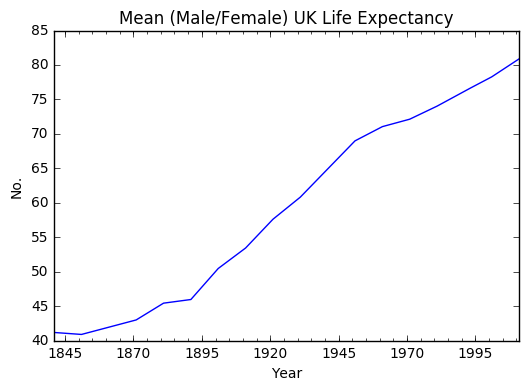

In [389]:
df_life_ex=df_life_ex.resample('AS').asfreq()
df_life_ex = df_life_ex.interpolate(method='linear', axis=0).ffill().bfill()
# Let's take the average of male and female
df_life_ex['ave']=(df_life_ex['Male']+df_life_ex['Female'])/2
df_life_ex.drop('Years spanned',axis=1,inplace=True)
df_life_ex.columns=['Year','Male','Female','ave']
ab=df_life_ex['ave'].plot()
ab.set_xlabel('Year')
ab.set_ylabel('No.')
ab.set_title('Mean (Male/Female) UK Life Expectancy')

# How many of the 2016 Deaths could we have 'expected' based on these life expectancy numbers?

Let's start by looking at the year of birth for everyone who died in 2016 and calculate the year we would have expected them to die, based on the life expectancy in the year they were born:

In [390]:
df_2016['YoB']=df_2016['YoB'].astype(str)
df_2016['YoB'] = df_2016['YoB'].apply(lambda d: datetime.strptime(d, "%Y"))
df_2016.index = df_2016['YoB']
df_2016.columns=['Age_at_death','YoB']

df_2016['life_ex']=df_life_ex['ave'].astype(int)
df_2016['exp YoD']=df_2016['YoB'] + df_2016['life_ex'].values.astype("timedelta64[Y]")


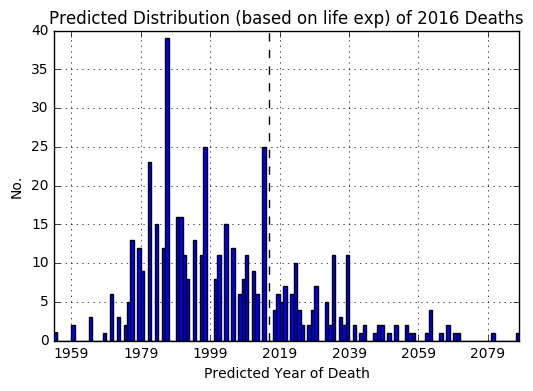

In [437]:
n_bins=int((max(df_2016['exp YoD'])-min(df_2016['exp YoD'])).days/365)
ap=df_2016['exp YoD'].hist(bins=n_bins)
ap.set_xlabel('Predicted Year of Death')
ap.set_ylabel('No.')
ap.set_title('Predicted Distribution (based on life exp) of 2016 Deaths')
ap.axvline(x=datetime.strptime('2016-01-01', "%Y-%m-%d"),color='k', linestyle='--')

This plot shows the distribution of which years the 2016 deaths would have occurred, had they matched the life expectancy of the year they were born

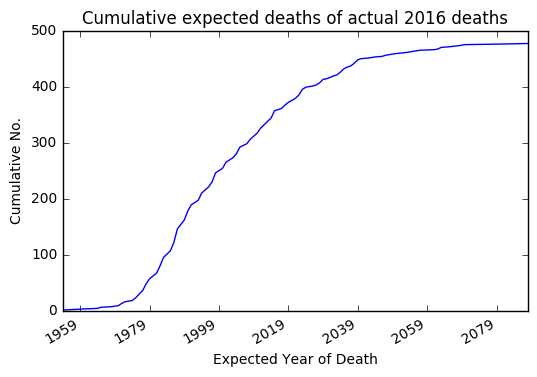

In [440]:
aq=df_2016['exp YoD'].value_counts().sort_index(ascending=True).cumsum().plot()
aq.set_ylabel('Cumulative No.')
aq.set_xlabel('Expected Year of Death')
aq.set_title('Cumulative expected deaths of actual 2016 deaths')

Remember that this plot is **theoretical** - it's describing what we would have **expected** to see, not what actually happened.

How does this compare with previous years?

In [35]:
# A function to get a list of death dates from wikipedia's 'Death in 
# XXXX Page - returns a list of ages at death
def get_year_deaths(year):
    ages=[]
    months = []
    # Get a list of months
    for i in range(1,13):
        months.append((datetime.date(2016, i, 1).strftime('%B')))
    expr = re.compile('\d+')
    
    # For each month
    for m in months:
        with urllib.request.urlopen('https://en.wikipedia.org/wiki/Deaths_in_'+m+'_'+str(year)) as response:
            soup = BeautifulSoup(response,'html5lib')
            data = soup.findAll('div',attrs={'class':'mw-content-ltr'})
            for div in data:
                search = div.findAll('li')
                for s in search:
                    if re.match("^[a-zA-Z]+.*", s.text):
                        if(s.text[0].isalpha()):
                            if(len(re.findall('\d+', s.text))>0):
                                if(int(re.findall('\d+', s.text)[0])<120):
                                    ages.append(int(re.findall('\d+', s.text)[0]))
    return ages

In [40]:
deaths_2015=get_year_deaths(2015)

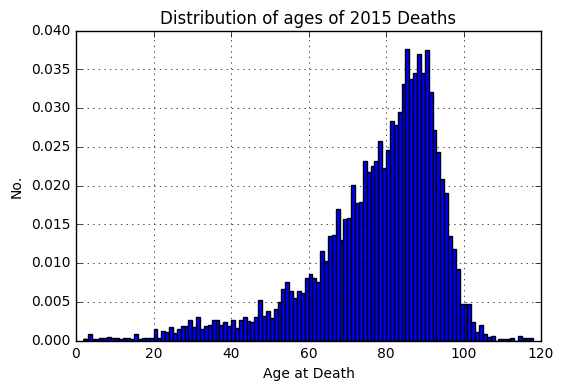

In [41]:
s_2015 = pd.Series(deaths_2015)
n_bins=int((max(s_2015)-min(s_2015)))
az=s_2015.hist(normed=True,bins=n_bins)
az.set_xlabel('Age at Death')
az.set_ylabel('No.')
az.set_title('Distribution of ages of 2015 Deaths')

In [42]:
deaths_2014=get_year_deaths(2014)

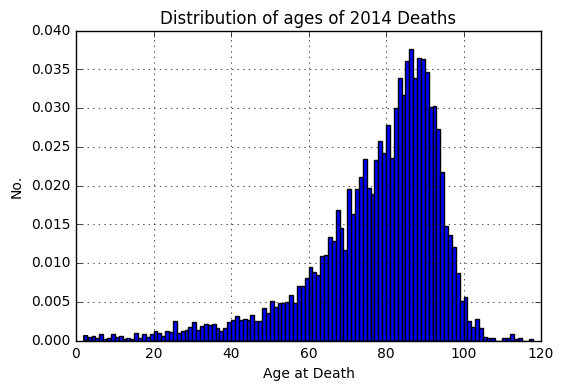

In [43]:
s_2014 = pd.Series(deaths_2014)
n_bins=int((max(s_2014)-min(s_2014)))
az=s_2014.hist(normed=True,bins=n_bins)
az.set_xlabel('Age at Death')
az.set_ylabel('No.')
az.set_title('Distribution of ages of 2014 Deaths')

In [46]:
deaths_2016_all=get_year_deaths(2016)

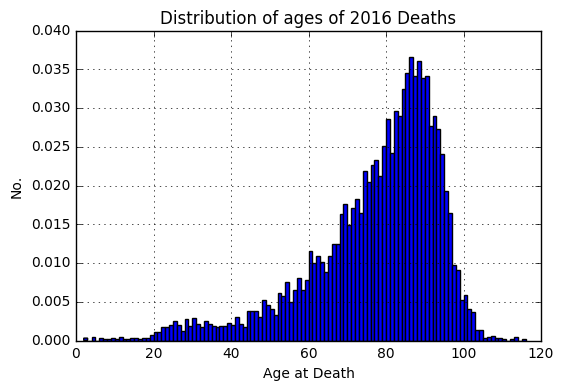

In [48]:
s_2016_all = pd.Series(deaths_2016_all)
n_bins=int((max(s_2016_all)-min(s_2016_all)))
az=s_2016_all.hist(normed=True,bins=n_bins)
az.set_xlabel('Age at Death')
az.set_ylabel('No.')
az.set_title('Distribution of ages of 2016 Deaths')

In [49]:
deaths_2013=get_year_deaths(2013)

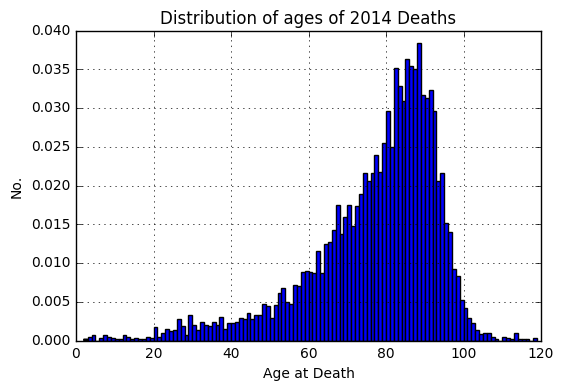

In [50]:
s_2013 = pd.Series(deaths_2013)
n_bins=int((max(s_2013)-min(s_2013)))
az=s_2013.hist(normed=True,bins=n_bins)
az.set_xlabel('Age at Death')
az.set_ylabel('No.')
az.set_title('Distribution of ages of 2013 Deaths')

In [51]:
deaths_2012=get_year_deaths(2012)

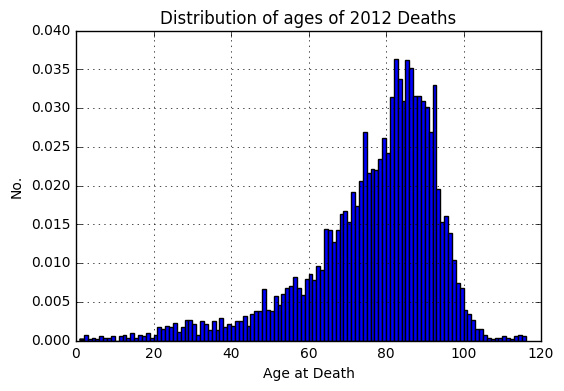

In [52]:
s_2012 = pd.Series(deaths_2012)
n_bins=int((max(s_2012)-min(s_2012)))
az=s_2012.hist(normed=True,bins=n_bins)
az.set_xlabel('Age at Death')
az.set_ylabel('No.')
az.set_title('Distribution of ages of 2012 Deaths')

In [53]:
deaths_2011=get_year_deaths(2011)

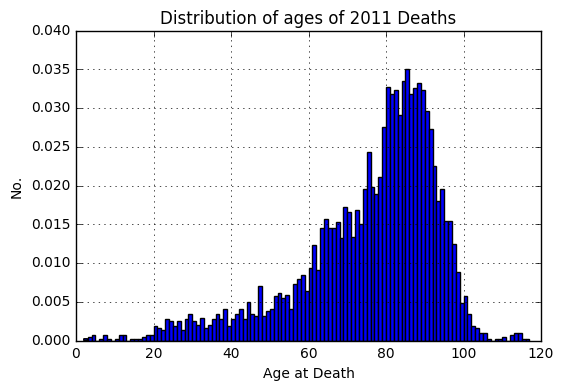

In [54]:
s_2011 = pd.Series(deaths_2011)
n_bins=int((max(s_2011)-min(s_2011)))
az=s_2011.hist(normed=True,bins=n_bins)
az.set_xlabel('Age at Death')
az.set_ylabel('No.')
az.set_title('Distribution of ages of 2011 Deaths')

In [55]:
deaths_2010=get_year_deaths(2010)

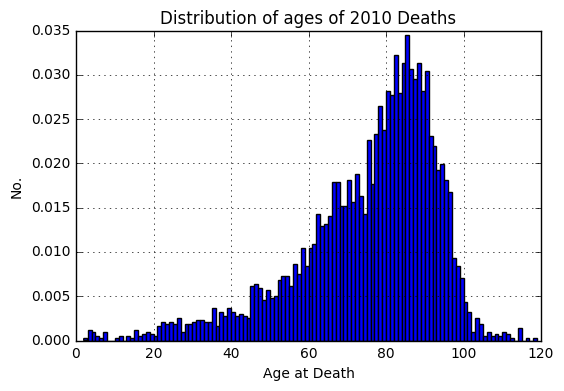

In [56]:
s_2010 = pd.Series(deaths_2010)
n_bins=int((max(s_2010)-min(s_2010)))
az=s_2010.hist(normed=True,bins=n_bins)
az.set_xlabel('Age at Death')
az.set_ylabel('No.')
az.set_title('Distribution of ages of 2010 Deaths')

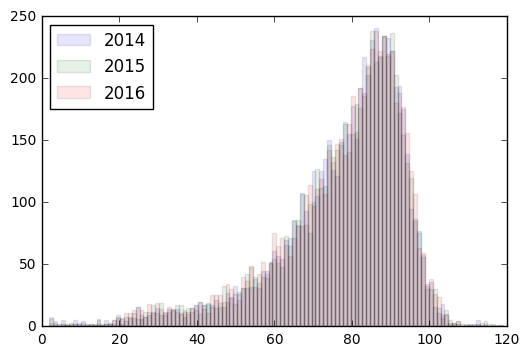

In [79]:

bins = np.linspace(min(s_2010),max(s_2010), int((max(s_2010)-min(s_2010))))
#bins = np.linspace(20,60, 40)


#plt.hist(s_2010, bins, alpha=0.2, label='2010')
#plt.hist(s_2011, bins, alpha=0.2, label='2011')
#plt.hist(s_2012, bins, alpha=0.2, label='2012')
#plt.hist(s_2013, bins, alpha=0.2, label='2013')
plt.hist(s_2014, bins, alpha=0.1, label='2014')
plt.hist(s_2015, bins, alpha=0.1, label='2015')
plt.hist(s_2016_all, bins, alpha=0.1, label='2016')
plt.legend(loc='upper left')
plt.show()

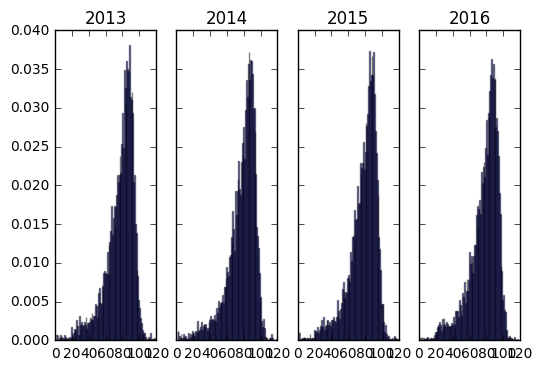

In [90]:
# Two subplots, unpack the axes array immediately
f, (ax0,ax1, ax2,ax3) = plt.subplots(1, 4, sharey=True)
ax0.hist(s_2013, bins, alpha=0.5, label='2013',normed=1)
ax0.set_title('2013')
ax1.hist(s_2014, bins, alpha=0.5, label='2014',normed=1)
ax1.set_title('2014')
ax2.hist(s_2015, bins, alpha=0.5, label='2015',normed=1)
ax2.set_title('2015')
ax3.hist(s_2016_all, bins, alpha=0.5, label='2016',normed=1)
ax3.set_title('2016')

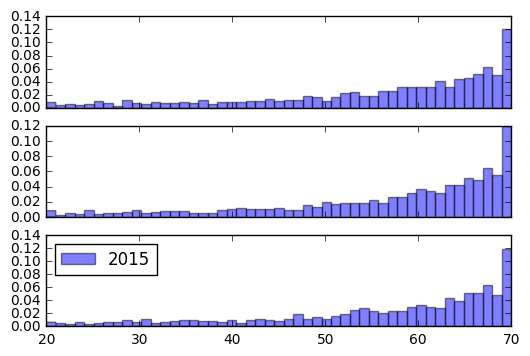

In [107]:
#bins = np.linspace(min(s_2010),max(s_2010), int((max(s_2010)-min(s_2010))))
bins = np.linspace(20,70, 50)

ax1 = plt.subplot(311)
plt.hist(s_2013, bins, alpha=0.5, label='2013',normed=1)
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(312, sharex=ax1)


plt.hist(s_2014, bins, alpha=0.5, label='2014',normed=1)
ax3 = plt.subplot(313, sharex=ax1, sharey=ax1,label='2014')


plt.setp(ax2.get_xticklabels(), visible=False)

plt.hist(s_2015, bins, alpha=0.5, label='2015',normed=1)
plt.legend(loc='upper left')


(250, 1750)

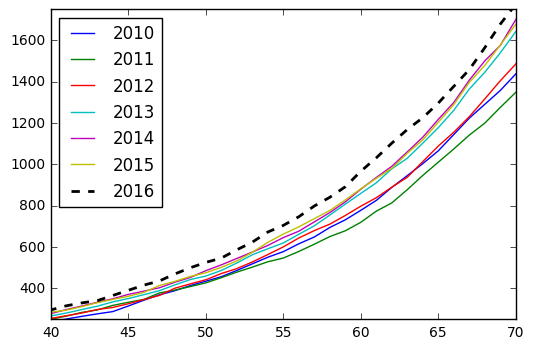

In [144]:
aq=s_2010.value_counts().sort_index(ascending=True).cumsum().plot(label='2010')
aq.plot(s_2011.value_counts().sort_index(ascending=True).cumsum(),label='2011')
aq.plot(s_2012.value_counts().sort_index(ascending=True).cumsum(),label='2012')
aq.plot(s_2013.value_counts().sort_index(ascending=True).cumsum(),label='2013')
aq.plot(s_2014.value_counts().sort_index(ascending=True).cumsum(),label='2014')
aq.plot(s_2015.value_counts().sort_index(ascending=True).cumsum(),label='2015')
aq.plot(s_2016_all.value_counts().sort_index(ascending=True).cumsum(),'--',linewidth=2,label='2016')
plt.legend(loc='upper left')
plt.xlim([40,70])
plt.ylim([250,1750])

In [126]:
s_2001 = pd.Series(get_year_deaths(2001))
s_2002 = pd.Series(get_year_deaths(2002))
s_2003 = pd.Series(get_year_deaths(2003))
s_2004 = pd.Series(get_year_deaths(2004))
s_2005 = pd.Series(get_year_deaths(2005))
s_2006 = pd.Series(get_year_deaths(2006))
s_2007 = pd.Series(get_year_deaths(2007))
s_2008 = pd.Series(get_year_deaths(2008))
s_2009 = pd.Series(get_year_deaths(2009))


(0, 2000)

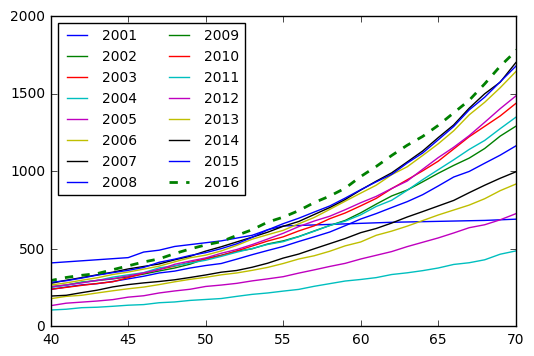

In [164]:
aq=s_2001.value_counts().sort_index(ascending=True).cumsum().plot(label='2001')
aq.plot(s_2002.value_counts().sort_index(ascending=True).cumsum(),label='2002')
aq.plot(s_2003.value_counts().sort_index(ascending=True).cumsum(),label='2003')
aq.plot(s_2004.value_counts().sort_index(ascending=True).cumsum(),label='2004')
aq.plot(s_2005.value_counts().sort_index(ascending=True).cumsum(),label='2005')
aq.plot(s_2006.value_counts().sort_index(ascending=True).cumsum(),label='2006')
aq.plot(s_2007.value_counts().sort_index(ascending=True).cumsum(),label='2007')
aq.plot(s_2008.value_counts().sort_index(ascending=True).cumsum(),label='2008')
aq.plot(s_2009.value_counts().sort_index(ascending=True).cumsum(),label='2009')
aq.plot(s_2010.value_counts().sort_index(ascending=True).cumsum(),label='2010')
aq.plot(s_2011.value_counts().sort_index(ascending=True).cumsum(),label='2011')
aq.plot(s_2012.value_counts().sort_index(ascending=True).cumsum(),label='2012')
aq.plot(s_2013.value_counts().sort_index(ascending=True).cumsum(),label='2013')
aq.plot(s_2014.value_counts().sort_index(ascending=True).cumsum(),label='2014')
aq.plot(s_2015.value_counts().sort_index(ascending=True).cumsum(),label='2015')
aq.plot(s_2016_all.value_counts().sort_index(ascending=True).cumsum(),'--',linewidth=2,label='2016')
plt.legend(loc='upper left',ncol=2,fontsize=10)
plt.xlim([40,70])
plt.ylim([0,2000])

In [159]:
s_2002 = pd.Series(get_year_deaths(2002))

#aq=s_2002.value_counts().sort_index(ascending=True).cumsum().plot(label='2002')

In [165]:
s_2002.head()

Series([], dtype: float64)